Loaded covariance matrix with shape: (400, 400)


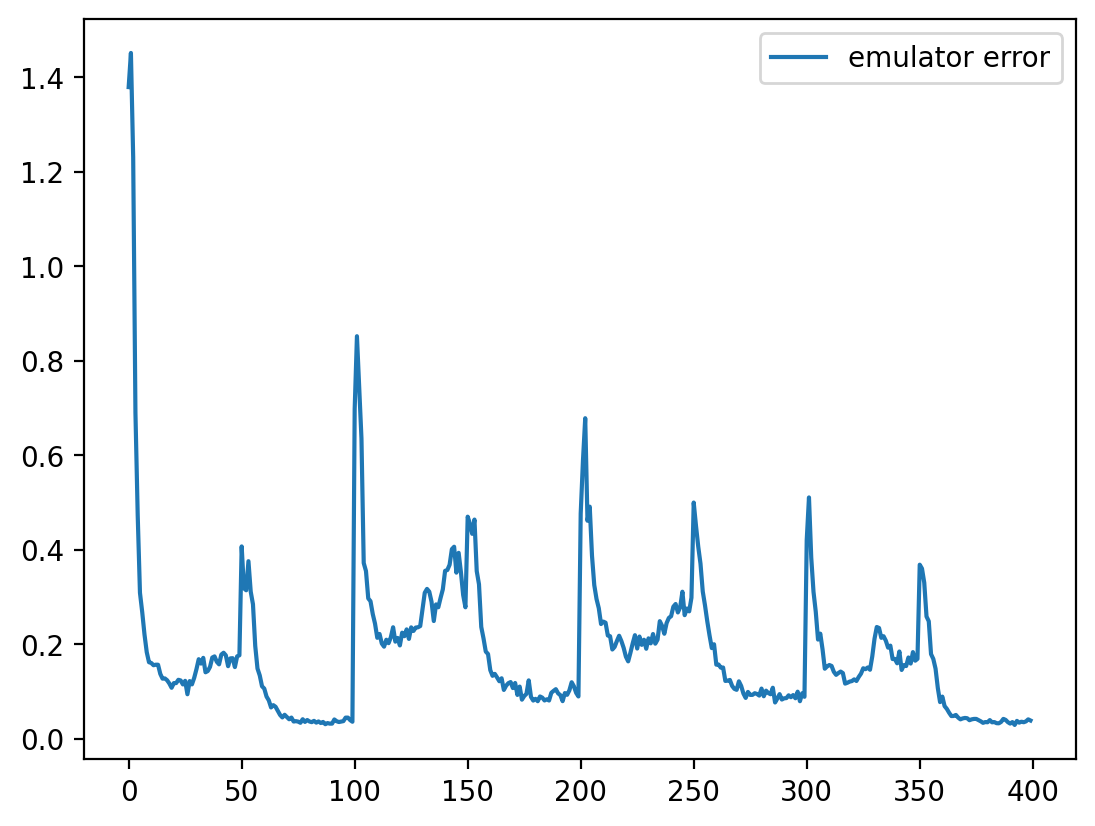

Loaded LHC with shape: (10000, 12), (10000, 400)


sample: 100%|██████████| 1100/1100 [00:42<00:00, 25.71it/s, 255 steps of size 1.89e-02. acc. prob=0.85]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     A_cen     -0.77      0.09     -0.78     -0.93     -0.64    415.48      1.01
     A_sat      0.08      0.52      0.09     -0.69      0.97    674.66      1.00
     B_cen     -0.55      0.03     -0.55     -0.60     -0.50    414.84      1.00
     B_sat     -0.20      0.40     -0.24     -0.86      0.37    212.69      1.00
     alpha      0.85      0.24      0.82      0.47      1.25    208.89      1.00
   alpha_c      0.27      0.09      0.30      0.14      0.40    207.12      1.00
   alpha_s      0.94      0.19      0.92      0.58      1.21    496.19      1.00
     kappa      0.54      0.25      0.56      0.19      0.99    315.67      1.02
    logM_1     14.64      0.26     14.67     14.27     15.08    381.01      1.00
  logM_cut     12.72      0.05     12.72     12.64     12.79    259.27      1.00
         s      0.07      0.56      0.05     -0.70      1.00    533.21      1.00
     sigma     -1.46      0

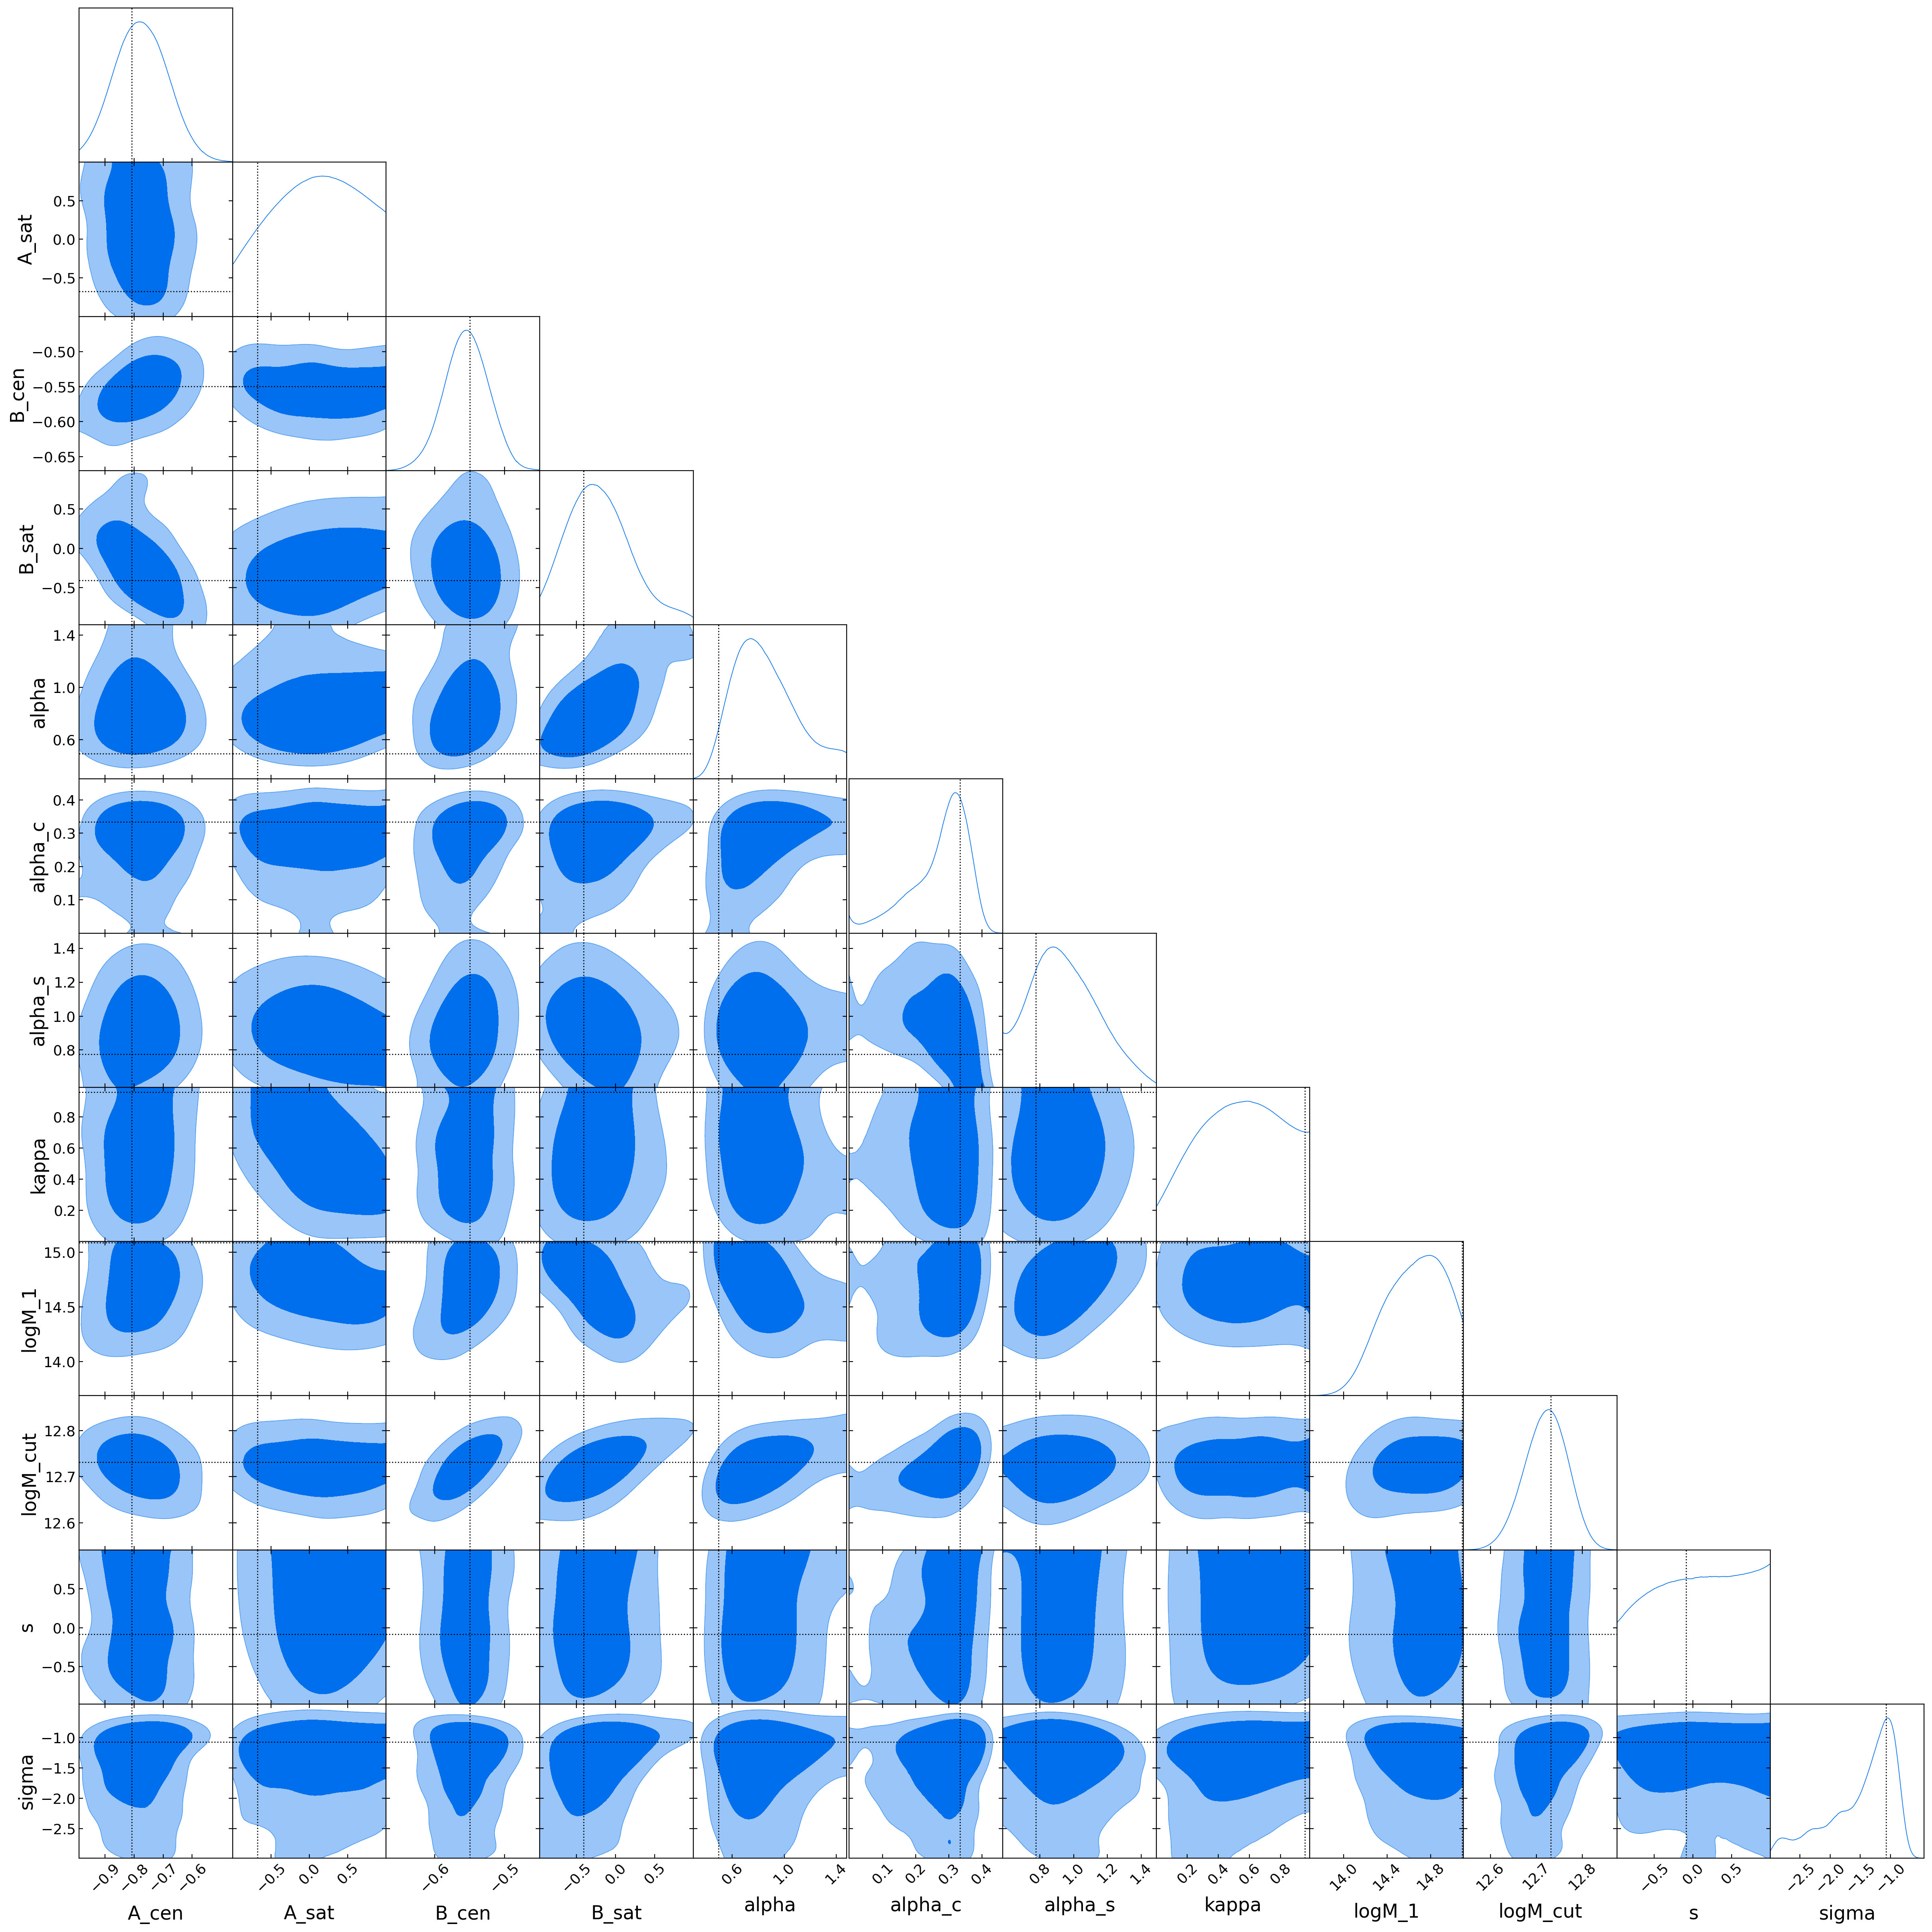

In [53]:
import scipy.stats as st
import numpy as np
from acm.observables import BaseObservable
from sunbird.emulators import FCN
from pycorr import TwoPointCorrelationFunction
from pathlib import Path
from numpyro import distributions as dist
from sunbird.inference.hamiltonian import HMC
import pandas
import glob
import torch
from astropy.stats import sigma_clip
import matplotlib.pyplot as plt
from getdist import plots, MCSamples
%matplotlib inline
%config InlineBackend.figure_format='retina'


def read_lhc(statistic='tpcf', return_sep=False):
    if statistic == 'tpcf':
        data_dir = f'/pscratch/sd/e/epaillas/emc/training_sets/tpcf/z0.5/yuan23_prior/c000_ph000/seed0/'
        data_fn = Path(data_dir) / 'tpcf_lhc.npy'
    elif statistic == 'density_split':
        data_dir = f'/pscratch/sd/e/epaillas/emc/training_sets/density_split/quantile_data_correlation/z0.5/yuan23_prior/c000_ph000/seed0/'
        data_fn = Path(data_dir) / 'quantile_data_correlation_lhc.npy'
    data = np.load(data_fn, allow_pickle=True).item()
    lhc_x = data['lhc_x']
    lhc_x_names = data['lhc_x_names']
    lhc_y = data['lhc_y']
    s = data['s']
    if return_sep:
        return s, lhc_x, lhc_y, lhc_x_names
    return lhc_x, lhc_y

def read_emulator_error(statistic='tpcf'):
    if statistic == 'tpcf':
        data_dir = '/pscratch/sd/e/epaillas/emc/training_sets/tpcf/z0.5/yuan23_prior/c000_ph000/seed0'
        data_fn = Path(data_dir) / 'tpcf_emulator_error.npy'
    elif statistic == 'density_split':
        data_dir = '/pscratch/sd/e/epaillas/emc/training_sets/density_split/quantile_data_correlation/z0.5/yuan23_prior/c000_ph000/seed0'
        data_fn = Path(data_dir) / 'quantile_data_correlation_emulator_error.npy'
    return np.load(data_fn, allow_pickle=True)
        

# def read_lhc(statistic='tpcf', n_hod=100, return_sep=False):
#     if statistic == 'tpcf':
#         data_dir = f'/pscratch/sd/e/epaillas/emc/training_sets/tpcf/z0.5/yuan23_prior/c000_ph000/seed0/'
#         lhc_y = []
#         for hod in range(n_hod):
#             data_fn = Path(data_dir) / f'tpcf_hod{hod:03}.npy'
#             data = TwoPointCorrelationFunction.load(data_fn)[::4]
#             s, multipoles = data(ells=(0, 2), return_sep=True)
#             lhc_y.append(np.concatenate(multipoles))
#     elif statistic == 'wp':
#         data_dir = f'/pscratch/sd/e/epaillas/emc/training_sets/wp/z0.5/yuan23_prior/c000_ph000/seed0/'
#         lhc_y = []
#         for hod in range(n_hod):
#             data_fn = Path(data_dir) / f'wp_hod{hod:03}.npy'
#             data = TwoPointCorrelationFunction.load(data_fn)
#             s, wp = data.sep, data.corr
#             lhc_y.append(wp)
#     elif statistic == 'density_split':
#         data_dir = f'/pscratch/sd/e/epaillas/emc/training_sets/{statistic}/quantile_data_correlation/z0.5/yuan23_prior/c000_ph000/seed0/'
#         lhc_y = []
#         for hod in range(n_hod):
#             data_fn = Path(data_dir) / f'quantile_data_correlation_hod{hod:03}.npy'
#             data = np.load(data_fn, allow_pickle=True)
#             multipoles_quantiles = []
#             for q in [0, 1, 3, 4]:
#                 result = data[q][::4]
#                 s, multipoles = result(ells=(0, 2), return_sep=True)
#                 multipoles_quantiles.append(np.concatenate(multipoles))
#             lhc_y.append(np.concatenate(multipoles_quantiles))
#     lhc_y = np.array(lhc_y)
#     lhc_x = pandas.read_csv('/pscratch/sd/e/epaillas/emc/hod_params/yuan23/hod_params_yuan23_c000.csv')
#     lhc_x_names = list(lhc_x.columns)
#     lhc_x_names = [name.replace(' ', '').replace('#', '') for name in lhc_x_names]
#     lhc_x = lhc_x.values[:len(lhc_y),:]
#     if return_sep:
#         return s, lhc_x, lhc_y, lhc_x_names
#     return lhc_x, lhc_y

def read_model(statistic='tpcf'):
    if statistic == 'tpcf':
        checkpoint_fn = glob.glob("/pscratch/sd/e/epaillas/emc/trained_models/tpcf/may22_leaveout_0/*.ckpt")[0]
    elif statistic == 'wp':
        checkpoint_fn = glob.glob(f'/pscratch/sd/e/epaillas/emc/trained_models/wp/may21_leaveout_0/*.ckpt')[0]
    elif statistic == 'density_split':
        checkpoint_fn = glob.glob(f'/pscratch/sd/e/epaillas/emc/trained_models/density_split/may20_leaveout_0/*.ckpt')[0]
    model = FCN.load_from_checkpoint(checkpoint_fn, strict=True)
    model.eval()
    return model

def read_covariance(statistic='tpcf'):
    if statistic == 'tpcf':
        data_dir = Path('/pscratch/sd/e/epaillas/emc/covariance_sets/tpcf/z0.5/yuan23_prior')
        data_fns = list(data_dir.glob('tpcf_ph*_hod466.npy'))
        multipoles_phases = []
        for data_fn in data_fns:
            data = TwoPointCorrelationFunction.load(data_fn)[::4]
            s, multipoles = data(ells=(0, 2), return_sep=True)
            multipoles_phases.append(np.concatenate(multipoles))
        multipoles_phases = np.array(multipoles_phases)
        prefactor = 1 / 8
        return prefactor * np.cov(multipoles_phases, rowvar=False)
    elif statistic == 'wp':
        data_dir = Path('/pscratch/sd/e/epaillas/emc/covariance_sets/wp/z0.5/yuan23_prior')
        data_fns = list(data_dir.glob('wp_ph*_hod466.npy'))
        wp_phases = []
        for data_fn in data_fns:
            data = TwoPointCorrelationFunction.load(data_fn)
            s, wp = data.sep, data.corr
            wp_phases.append(wp)
        wp_phases = np.array(wp_phases)
        prefactor = 1 / 8
        return prefactor * np.cov(wp_phases, rowvar=False)
    elif statistic == 'density_split':
        data_dir = Path('/pscratch/sd/e/epaillas/emc/covariance_sets/density_split/quantile_data_correlation/z0.5/yuan23_prior')
        data_fns = list(data_dir.glob('quantile_data_correlation_ph*_hod466.npy'))
        multipoles_phases = []
        for data_fn in data_fns:
            data = np.load(data_fn, allow_pickle=True)
            multipoles_quantiles = []
            for q in (0, 1, 3, 4):
                multipoles = data[q][::4](ells=(0, 2))
                multipoles_quantiles.append(np.concatenate(multipoles))
            multipoles_phases.append(np.concatenate(multipoles_quantiles))
        multipoles_phases = np.array(multipoles_phases)
        prefactor = 1 / 64
        return prefactor * np.cov(multipoles_phases, rowvar=False)


statistic = 'density_split'

fig, ax = plt.subplots()

covariance_matrix = read_covariance(statistic=statistic)
print(f'Loaded covariance matrix with shape: {covariance_matrix.shape}')
# ax.plot(np.sqrt(np.diag(covariance_matrix)), label='data error')

emulator_error = read_emulator_error(statistic=statistic)
ax.plot(emulator_error/np.sqrt(np.diag(covariance_matrix)), label='emulator error')
covariance_matrix += np.diag(emulator_error ** 2)
ax.legend()
plt.show()

precision_matrix = np.linalg.inv(covariance_matrix)

# load the data
s, lhc_x, lhc_y, lhc_x_names = read_lhc(statistic=statistic, return_sep=True)
print(f'Loaded LHC with shape: {lhc_x.shape}, {lhc_y.shape}')

# mask outliers
# mask = sigma_clip(lhc_y, sigma=6, axis=0, masked=True).mask
# mask = np.all(~mask, axis=1)
# lhc_x = lhc_x[mask]
# lhc_y = lhc_y[mask]
# print(f'After sigma clipping: {lhc_x.shape}, {lhc_y.shape}')

lhc_test_x = lhc_x[:int(len(lhc_y) / 5)]
lhc_test_y = lhc_y[:int(len(lhc_y) / 5)]



priors = {
    'logM_cut': dist.Uniform(low=12.5, high=13.7),
    'logM_1': dist.Uniform(low=13.6, high=15.1),
    'sigma': dist.Uniform(low=-2.99, high=0.96),
    'alpha': dist.Uniform(low=0.3, high=1.48),
    'kappa': dist.Uniform(low=0., high=0.99),
    'alpha_c': dist.Uniform(low=0., high=0.61),
    'alpha_s': dist.Uniform(low=0.58, high=1.49),
    's': dist.Uniform(low=-0.98, high=1.),
    'A_cen': dist.Uniform(low=-0.99, high=0.93),
    'A_sat': dist.Uniform(low=-1., high=1.),
    'B_cen': dist.Uniform(low=-0.67, high=0.2),
    'B_sat': dist.Uniform(low=-0.97, high=0.99),
}

getdist_priors = {
    'logM_cut': [12.5, 13.7],
    'logM_1': [13.6, 15.1],
    'sigma': [-2.99, 0.96],
    'alpha': [0.3, 1.48],
    'kappa': [0., 0.99],
    'alpha_c': [0., 0.61],
    'alpha_s': [0.58, 1.49],
    's': [-0.98, 1.],
    'A_cen': [-0.99, 0.93],
    'A_sat': [-1., 1.],
    'B_cen': [-0.67, 0.2],
    'B_sat': [-0.97, 0.99],
}

for idx_fit in range(1, 2):


    # load the model
    model = read_model(statistic=statistic)
    nn_model, nn_params = model.to_jax()

    with torch.no_grad():
        pred_test_y = model.get_prediction(torch.Tensor(lhc_test_x))
        pred_test_y = pred_test_y.numpy()

    hmc = HMC(
        observation=lhc_test_y[idx_fit],
        # observation=pred_test_y[idx_fit],
        precision_matrix=precision_matrix,
        nn_theory_model = nn_model,
        nn_parameters = nn_params,
        priors=priors,
    )
    
#     fig, ax = plt.subplots()
#     prior_samples = hmc.sanity_check_prior(n_samples=100)

#     # let's plot some predictions vs truth
#     for i in range(len(prior_samples)):
#         plt.plot(s, s**2*prior_samples[i][:len(s)], color='lightgray', alpha=0.5,)
#         plt.plot(s, s**2*prior_samples[i][len(s):], color='lightgray', alpha=0.5,)

#     errors = np.sqrt(np.diag(covariance_matrix))
#     ax.errorbar(s, s**2 * pred_test_y[idx_fit][:len(s)], s**2 * errors[:len(s)])
#     ax.errorbar(s, s**2 * pred_test_y[idx_fit][len(s):], s**2 * errors[len(s):])
#     plt.show()

    posterior = hmc()

    posterior_array = np.stack(list(posterior.values()), axis=0)
    chain = MCSamples(
            samples=posterior_array.T,
            weights=np.ones(posterior_array.shape[-1]),
            names=list(posterior.keys()),
            ranges=getdist_priors,
        )

    try:
        g = plots.get_subplot_plotter()
        g.settings.constrained_layout = True
        g.settings.axis_marker_lw = 1.0
        g.settings.axis_marker_ls = ":"
        g.settings.title_limit_labels = False
        g.settings.axis_marker_color = "k"
        g.settings.legend_colored_text = True
        g.settings.figure_legend_frame = False
        g.settings.linewidth_contour = 1.0
        g.settings.legend_fontsize = 22
        g.settings.axes_fontsize = 16
        g.settings.axes_labelsize = 20
        g.settings.axis_tick_x_rotation = 45
        g.settings.axis_tick_max_labels = 6

        g.triangle_plot(
            roots=[chain],
            filled=True,
            markers=dict(zip(lhc_x_names, lhc_test_x[idx_fit]))
        )
        # plt.savefig(f'posterior_{statistic}_hod{idx_fit}.pdf', bbox_inches='tight')
        # plt.show()
    except:
        continue

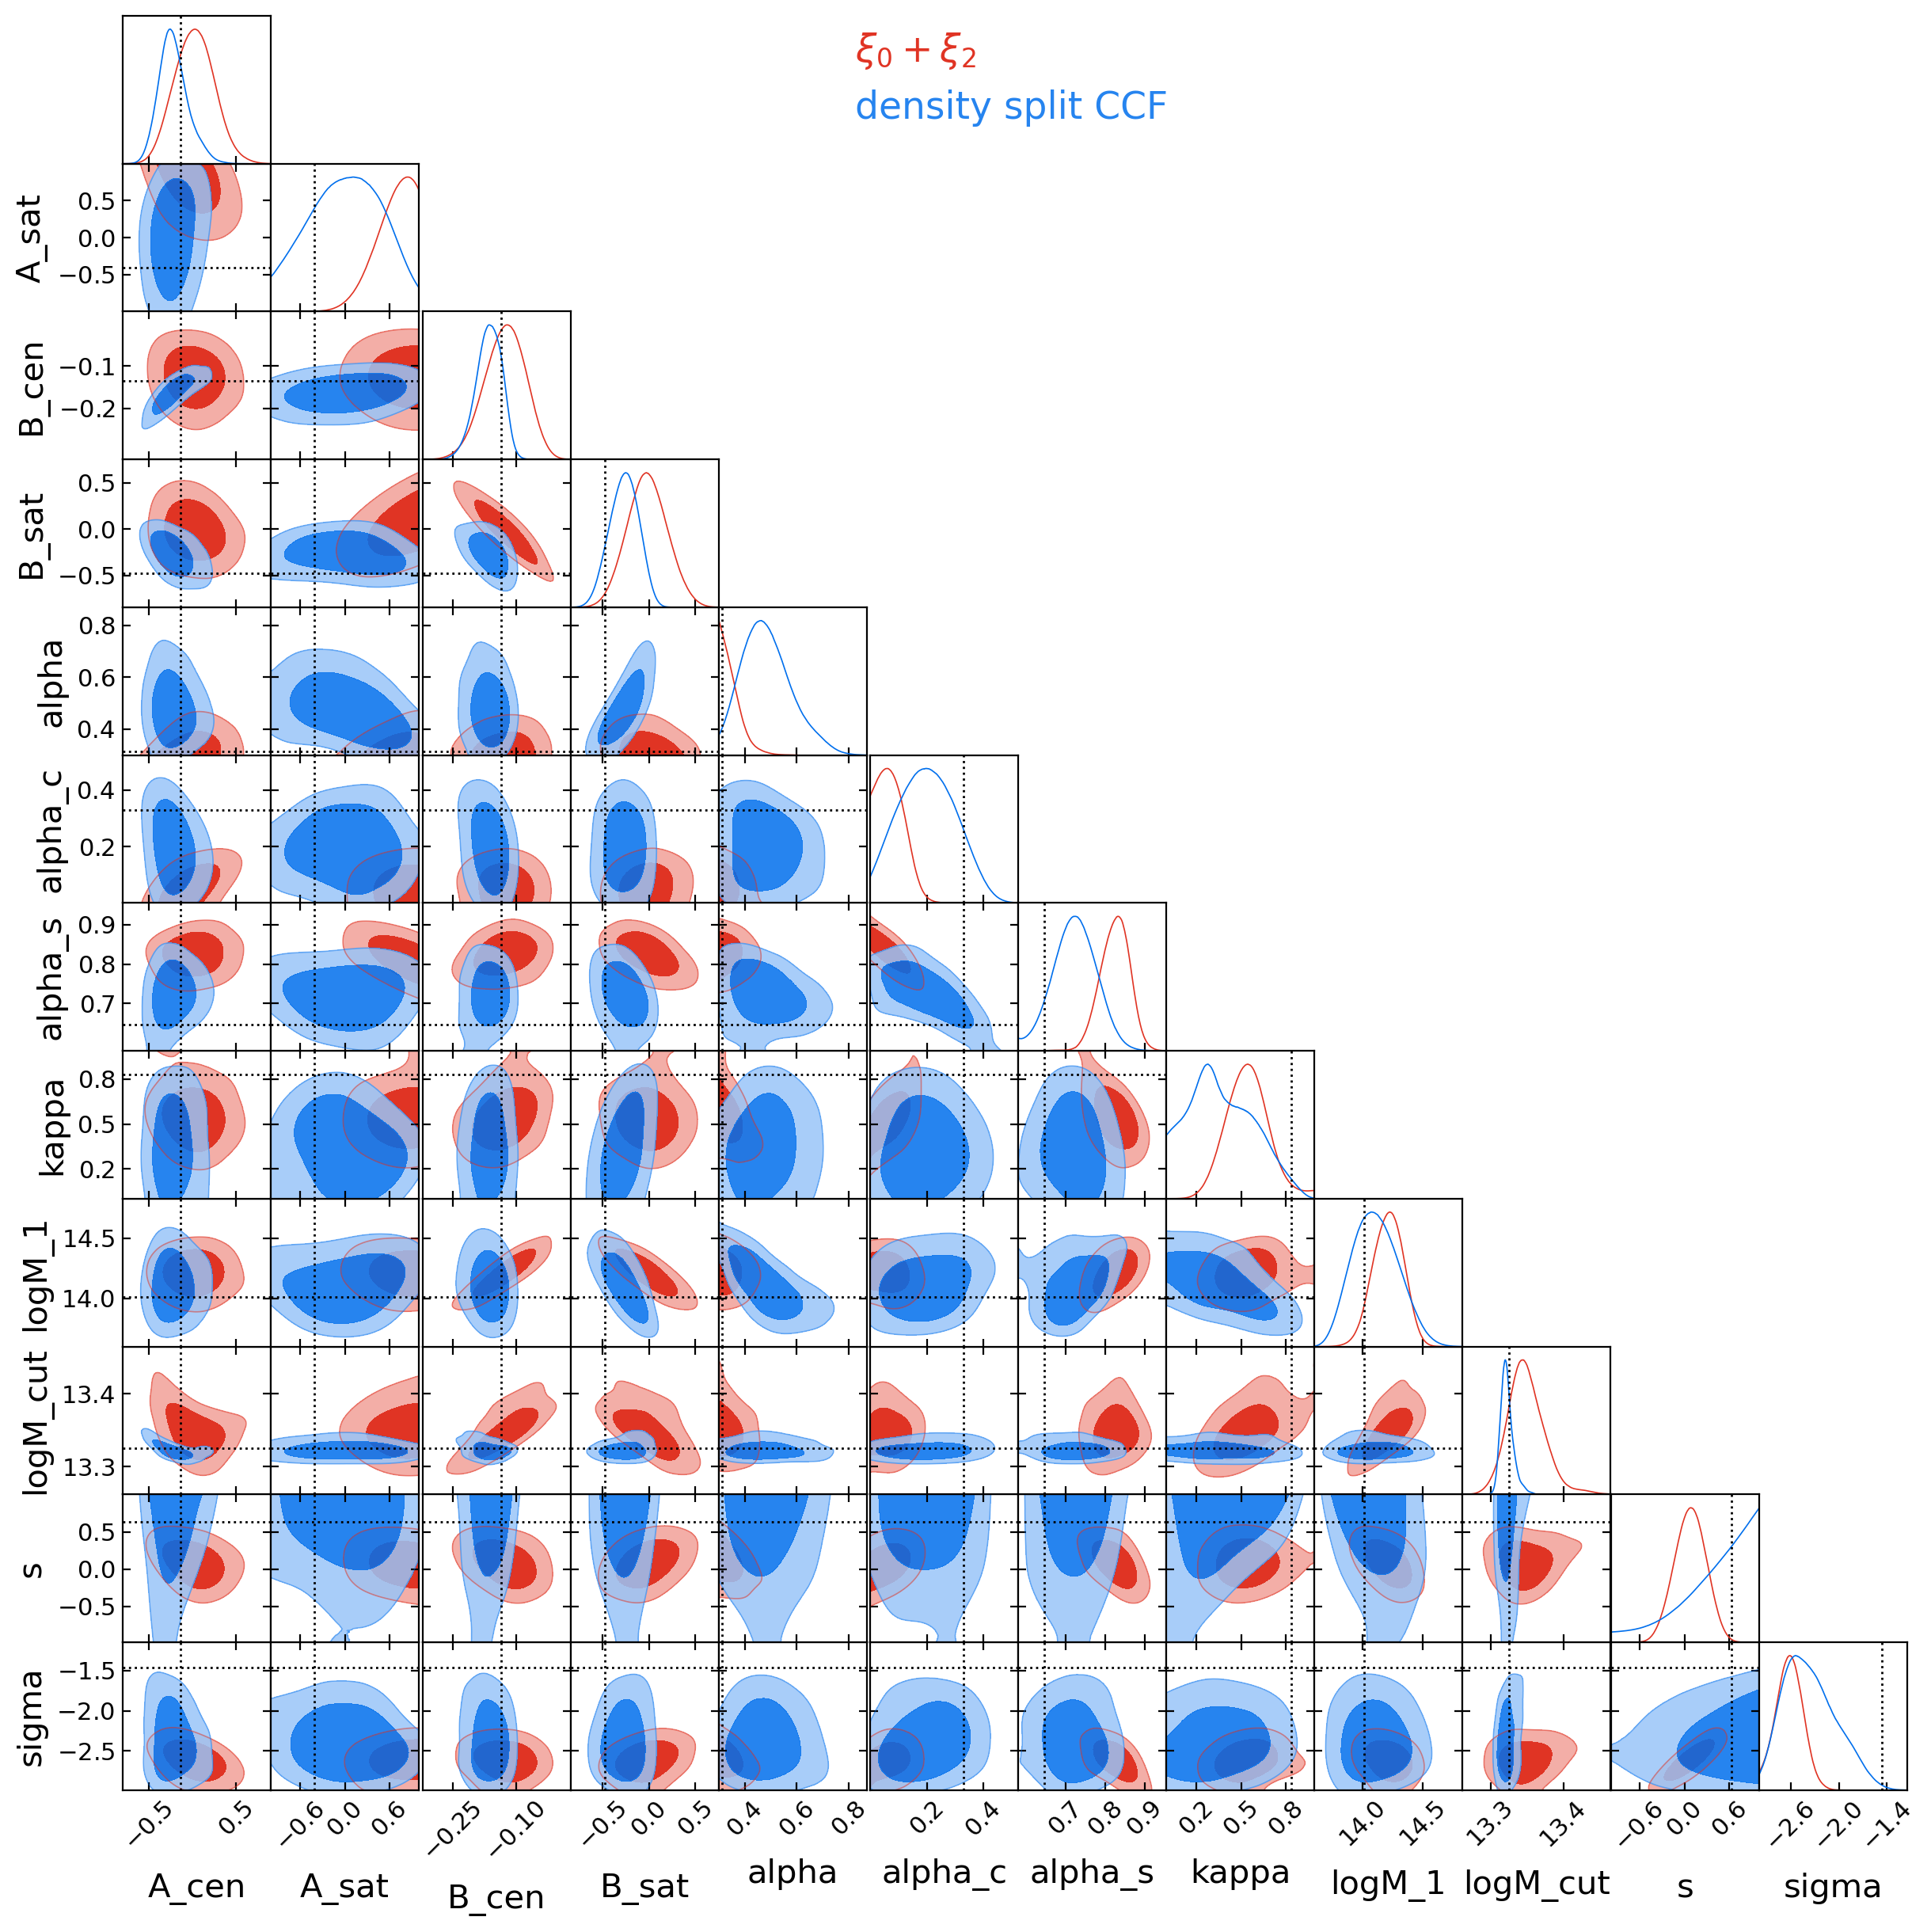

In [35]:
g = plots.get_subplot_plotter(width_inch=12)
g.settings.constrained_layout = True
g.settings.axis_marker_lw = 1.0
g.settings.axis_marker_ls = ":"
g.settings.title_limit_labels = False
g.settings.axis_marker_color = "k"
g.settings.legend_colored_text = True
g.settings.figure_legend_frame = False
g.settings.linewidth_contour = 1.0
g.settings.legend_fontsize = 22
g.settings.axes_fontsize = 16
g.settings.axes_labelsize = 20
g.settings.axis_tick_x_rotation = 45
g.settings.axis_tick_max_labels = 6

g.triangle_plot(
    roots=[chain_tpcf, chain_ds],
    legend_labels=[r'$\xi_0 + \xi_2$', 'density split CCF'],
    filled=True,
    markers=dict(zip(lhc_x_names, lhc_test_x[idx_fit]))
)
plt.savefig(f'posterior_hod{idx_fit}_biases.pdf', bbox_inches='tight')
plt.show()
